# MLOceanEnsemble for the Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

## ML ensemble

In [6]:
ls = [6, 7, 8, 9]

In [7]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

### Seeded ModelError

First instance with seed 

In [31]:
mekl0 = ModelErrorKL.ModelErrorKL(**args_list[0], **init_model_error_basis_args, xorwow_seed=1, np_seed=1)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

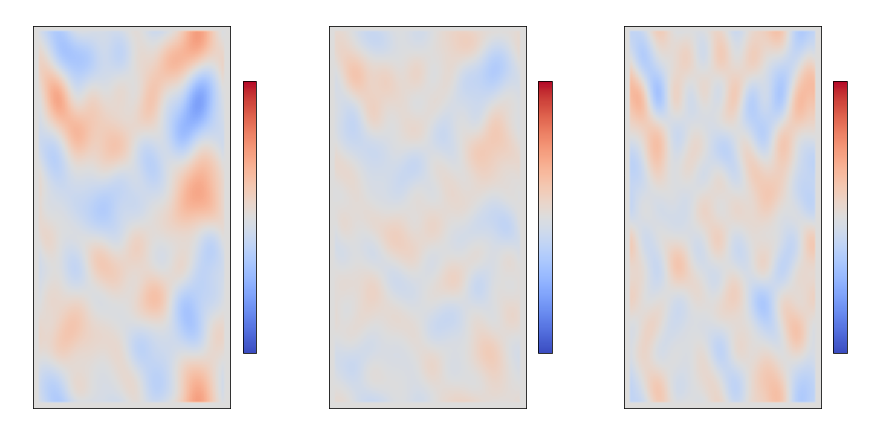

In [26]:
eta0 = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))
hu0  = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))
hv0  = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))

H = Common.Bathymetry(gpu_ctx, gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, 60 * np.ones((args_list[0]["ny"]+5, args_list[0]["nx"]+5)), args_list[0]["boundary_conditions"])

mekl0.perturbOceanState(eta0, hu0, hv0, H.Bi, args_list[0]["dx"], args_list[0]["dy"], 0.0012)

imshow3([eta0.download(gpu_stream), hu0.download(gpu_stream), hv0.download(gpu_stream)], eta_vlim=0.5, huv_vlim=50)

Just for reference a new sample

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

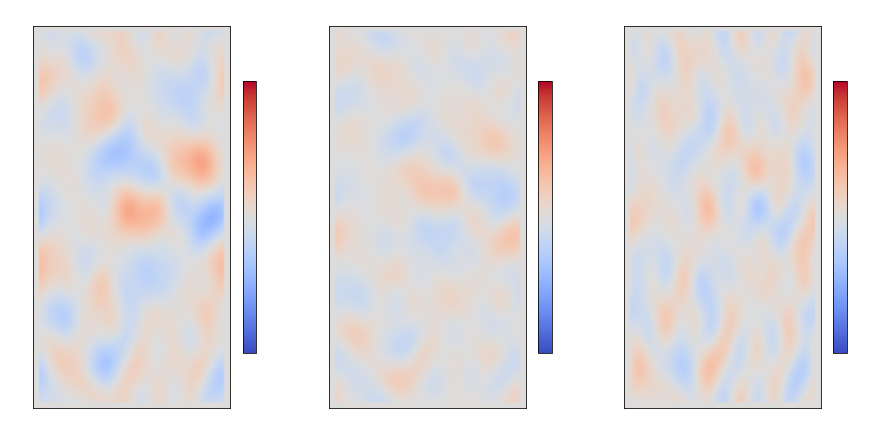

In [27]:
eta = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))
hu  = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))
hv  = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))

H = Common.Bathymetry(gpu_ctx, gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, 60 * np.ones((args_list[0]["ny"]+5, args_list[0]["nx"]+5)), args_list[0]["boundary_conditions"])

mekl0.perturbOceanState(eta, hu, hv, H.Bi, args_list[0]["dx"], args_list[0]["dy"], 0.0012)

imshow3([eta.download(gpu_stream), hu.download(gpu_stream), hv.download(gpu_stream)], eta_vlim=0.5, huv_vlim=50)

New instance with same seeds

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

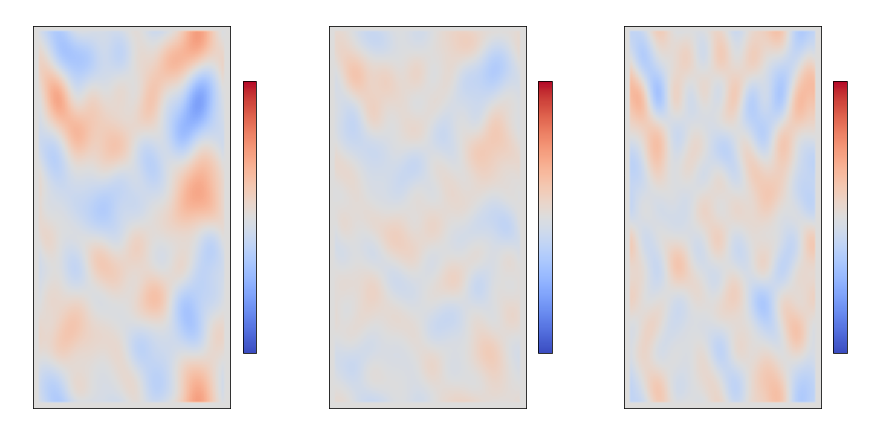

In [28]:
mekl1 = ModelErrorKL.ModelErrorKL(**args_list[0], **init_model_error_basis_args, xorwow_seed=1, np_seed=1)

eta1 = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))
hu1  = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))
hv1  = Common.CUDAArray2D(gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, np.zeros((args_list[0]["ny"]+4, args_list[0]["nx"]+4)))

H = Common.Bathymetry(gpu_ctx, gpu_stream, args_list[0]["nx"], args_list[0]["ny"], 2, 2, 60 * np.ones((args_list[0]["ny"]+5, args_list[0]["nx"]+5)), args_list[0]["boundary_conditions"])

mekl1.perturbOceanState(eta1, hu1, hv1, H.Bi, args_list[0]["dx"], args_list[0]["dy"], 0.0012)

imshow3([eta1.download(gpu_stream), hu1.download(gpu_stream), hv1.download(gpu_stream)], eta_vlim=0.5, huv_vlim=50)

Checking the differences

In [30]:
(eta0.download(gpu_stream) - eta1.download(gpu_stream)).max(), (eta0.download(gpu_stream) - eta.download(gpu_stream)).max()

(0.0, 0.3317206)